Dive into Axes.plot

In [1]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

import numpy as np

# Plot方法的环境

plot是Axes类的方法：

```python
class Axes(_AxesBase):
    
class _AxesBase(martist.Artist):
    
class Artist:
    """
    Abstract base class for objects that render into a FigureCanvas.
    在FigureCanvas中渲染的对象的抽象基类
    
    Typically, all visible elements in a figure are subclasses of Artist.
    一般，在图中的所有可见元素都是Artist的子类
    """
```

# Plot方法的实现

```python
#### Basic plotting

# Uses a custom implementation of data-kwarg handling in
# _process_plot_var_args.
@docstring.dedent_interpd
def plot(self, *args, scalex=True, scaley=True, data=None, **kwargs):
    kwargs = cbook.normalize_kwargs(kwargs, mlines.Line2D)
    lines = [*self._get_lines(*args, data=data, **kwargs)]
    for line in lines:
        self.add_line(line)
    self._request_autoscale_view(scalex=scalex, scaley=scaley)
    return lines
```

方法的核心语句是：
```
lines = [*self._get_lines(*args, data=data, **kwargs)]
for line in lines:
    self.add_line(line)
```
实现将Line2D实例加入Axes.lines属性

## 1. _get_lines属性

_get_lines属性是在_AxesBase类的cla方法中定义的
```python
class _AxesBase(martist.Artist):
    def cla(self):
        self._get_lines = _process_plot_var_args(self)
```

In [4]:
help(Axes._get_lines)

AttributeError: type object 'Axes' has no attribute '_get_lines'

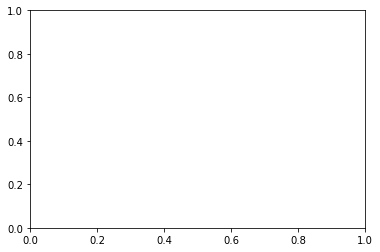

In [5]:
fig, ax = plt.subplots()

In [6]:
ax._get_lines?

Signature:   ax._get_lines(*args, **kwargs)
Type:        _process_plot_var_args
String form: <matplotlib.axes._base._process_plot_var_args object at 0x000001C7CE1A6D88>
File:        c:\users\gu\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py
Docstring:  
Process variable length arguments to the plot command, so that
plot commands like the following are supported::

  plot(t, s)
  plot(t1, s1, t2, s2)
  plot(t1, s1, 'ko', t2, s2)
  plot(t1, s1, 'ko', t2, s2, 'r--', t3, e3)

an arbitrary number of *x*, *y*, *fmt* are allowed


## 1.1. class _process_plot_var_args

```python
class _process_plot_var_args:
    """
    Process variable length arguments to the plot command, so that
    plot commands like the following are supported::

      plot(t, s)
      plot(t1, s1, t2, s2)
      plot(t1, s1, 'ko', t2, s2)
      plot(t1, s1, 'ko', t2, s2, 'r--', t3, e3)

    an arbitrary number of *x*, *y*, *fmt* are allowed
    """
    def __init__(self, axes, command='plot'):
        self.axes = axes
        self.command = command
        self.set_prop_cycle()
```

\_process_plot_var_args类是为了处理plot命令的可变长度参数。

### 1.1.1. \_process_plot_var_args.\_\_call\_\_(self, *args, **kwargs)

```python
def __call__(self, *args, **kwargs):
    self.axes._process_unit_info(kwargs=kwargs)

    for pos_only in "xy":
        if pos_only in kwargs:
            raise TypeError("{} got an unexpected keyword argument {!r}"
                            .format(self.command, pos_only))

    if not args:
        return

    # Process the 'data' kwarg.
    data = kwargs.pop("data", None)
    if data is not None:
        replaced = [mpl._replacer(data, arg) for arg in args]
        if len(args) == 1:
            label_namer_idx = 0
        elif len(args) == 2:  # Can be x, y or y, c.
            # Figure out what the second argument is.
            # 1) If the second argument cannot be a format shorthand, the
            #    second argument is the label_namer.
            # 2) Otherwise (it could have been a format shorthand),
            #    a) if we did perform a substitution, emit a warning, and
            #       use it as label_namer.
            #    b) otherwise, it is indeed a format shorthand; use the
            #       first argument as label_namer.
            try:
                _process_plot_format(args[1])
            except ValueError:  # case 1)
                label_namer_idx = 1
            else:
                if replaced[1] is not args[1]:  # case 2a)
                    cbook._warn_external(
                        f"Second argument {args[1]!r} is ambiguous: could "
                        f"be a format string but is in 'data'; using as "
                        f"data.  If it was intended as data, set the "
                        f"format string to an empty string to suppress "
                        f"this warning.  If it was intended as a format "
                        f"string, explicitly pass the x-values as well.  "
                        f"Alternatively, rename the entry in 'data'.",
                        RuntimeWarning)
                    label_namer_idx = 1
                else:  # case 2b)
                    label_namer_idx = 0
        elif len(args) == 3:
            label_namer_idx = 1
        else:
            raise ValueError(
                "Using arbitrary long args with data is not supported due "
                "to ambiguity of arguments; use multiple plotting calls "
                "instead")
        if kwargs.get("label") is None:
            kwargs["label"] = mpl._label_from_arg(
                replaced[label_namer_idx], args[label_namer_idx])
        args = replaced

    # Repeatedly grab (x, y) or (x, y, format) from the front of args and
    # massage them into arguments to plot() or fill().
    while args:
        this, args = args[:2], args[2:]
        if args and isinstance(args[0], str):
            this += args[0],
            args = args[1:]
        yield from self._plot_args(this, kwargs)
```

为了简化__call__方法，我们删除以下代码：
1. 处理data关键字参数相关部分
2. 健壮性相关部分
3. self.axes._process_unit_info(kwargs=kwargs)

```python
def __call__(self, *args, **kwargs):
    # Repeatedly grab (x, y) or (x, y, format) from the front of args and
    # massage them into arguments to plot() or fill().
    while args:
        this, args = args[:2], args[2:]
        if args and isinstance(args[0], str):
            this += args[0],
            args = args[1:]
        yield from self._plot_args(this, kwargs)
```

我们定义一个简单的函数来模拟plot

In [20]:
def plot_args(tup, kwargs):
    return len(tup)

In [21]:
def simplot(*args, **kwargs):
    # lines = [*self._get_lines(*args, data=data, **kwargs)]
    lines = []
    while args:
        this, args = args[:2], args[2:]
        if args and isinstance(args[0], str):
            this += args[0],
            args = args[1:]
            lines.append(plot_args(this, kwargs))
    return lines

In [22]:
t = np.arange(0.0, 2.0, 0.05)
simplot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')

[3, 3, 3]

### 1.1.1.1. \_process_plot_var_args.\_plot\_args(self, tup, kwargs)

```python
def _plot_args(self, tup, kwargs):
    if len(tup) > 1 and isinstance(tup[-1], str):
        linestyle, marker, color = _process_plot_format(tup[-1])
        tup = tup[:-1]
    elif len(tup) == 3:
        raise ValueError('third arg must be a format string')
    else:
        linestyle, marker, color = None, None, None

    # Don't allow any None value; these would be up-converted to one
    # element array of None which causes problems downstream.
    if any(v is None for v in tup):
        raise ValueError("x, y, and format string must not be None")

    kw = {}
    for k, v in zip(('linestyle', 'marker', 'color'),
                    (linestyle, marker, color)):
        if v is not None:
            kw[k] = v

    if len(tup) == 2:
        x = _check_1d(tup[0])
        y = _check_1d(tup[-1])
    else:
        x, y = index_of(tup[-1])

    if self.axes.xaxis is not None:
        self.axes.xaxis.update_units(x)
    if self.axes.yaxis is not None:
        self.axes.yaxis.update_units(y)

    if x.shape[0] != y.shape[0]:
        raise ValueError(f"x and y must have same first dimension, but "
                         f"have shapes {x.shape} and {y.shape}")
    if x.ndim > 2 or y.ndim > 2:
        raise ValueError(f"x and y can be no greater than 2-D, but have "
                         f"shapes {x.shape} and {y.shape}")
    if x.ndim == 1:
        x = x[:, np.newaxis]
    if y.ndim == 1:
        y = y[:, np.newaxis]

    if self.command == 'plot':
        func = self._makeline
    else:
        kw['closed'] = kwargs.get('closed', True)
        func = self._makefill

    ncx, ncy = x.shape[1], y.shape[1]
    if ncx > 1 and ncy > 1 and ncx != ncy:
        cbook.warn_deprecated(
            "2.2", message="cycling among columns of inputs with "
            "non-matching shapes is deprecated.")
    return [func(x[:, j % ncx], y[:, j % ncy], kw, kwargs)
            for j in range(max(ncx, ncy))]

```

为了简化_plot_args方法，我们删除以下代码：
1. 处理fmt参数相关部分
2. 健壮性相关部分


3. self.axes._process_unit_info(kwargs=kwargs)

```python
def _plot_args(self, tup, kwargs):

    if len(tup) > 1 and isinstance(tup[-1], str):
        linestyle, marker, color = _process_plot_format(tup[-1])
        tup = tup[:-1]
    elif len(tup) == 3:
        raise ValueError('third arg must be a format string')
    else:
        linestyle, marker, color = None, None, None
        
    if len(tup) == 2:
        x = _check_1d(tup[0])
        y = _check_1d(tup[-1])
    else:
        x, y = index_of(tup[-1])

    if self.axes.xaxis is not None:
        self.axes.xaxis.update_units(x)
    if self.axes.yaxis is not None:
        self.axes.yaxis.update_units(y)

    if x.ndim == 1:
        x = x[:, np.newaxis]
    if y.ndim == 1:
        y = y[:, np.newaxis]

    if self.command == 'plot':
        func = self._makeline
    else:
        kw['closed'] = kwargs.get('closed', True)
        func = self._makefill

    ncx, ncy = x.shape[1], y.shape[1]
    return [func(x[:, j % ncx], y[:, j % ncy], kw, kwargs)
            for j in range(max(ncx, ncy))]

```

1. 处理fmt参数，tup = tup[:-1]
2. 如果tup包含(x,y)两个元素 _check_1d分别效验；如果tup只包含一个元素，index_of补全(x,y)两个元素
3. update_units
4. 选择绘制方法，'plot'对应_makeline （class _process_plot_var_args 的 command属性不值在什么情况下会改变？）
5. 处理多维x,y数据
6. 调用_makeline

In [30]:
[j for j in range(5)]

[0, 1, 2, 3, 4]

In [40]:
np.array(np.arange(0,10,1))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

**deep**

1. _process_plot_var_args.__call__(self, *args, **kwargs)
2. _process_plot_var_args._plot_args(self, tup, kwargs)

```python
self._get_lines = _process_plot_var_args(self)

def plot(self, *args, scalex=True, scaley=True, data=None, **kwargs):
    kwargs = cbook.normalize_kwargs(kwargs, mlines.Line2D)
    lines = [*self._get_lines(*args, data=data, **kwargs)]
```

在plot方法的内部，args 与 kwargs 被用来调用_get_lines方法

# 1.

### class _process_plot_var_args(object):

```python
class _process_plot_var_args(object):
    """
    Process variable length arguments to the plot command, so that
    plot commands like the following are supported::

      plot(t, s)
      plot(t1, s1, t2, s2)
      plot(t1, s1, 'ko', t2, s2)
      plot(t1, s1, 'ko', t2, s2, 'r--', t3, e3)

    an arbitrary number of *x*, *y*, *fmt* are allowed
    """
    
    def __call__(self, *args, **kwargs):
        # Process units.
        if self.axes.xaxis is not None and self.axes.yaxis is not None:
            xunits = kwargs.pop('xunits', self.axes.xaxis.units)
            if self.axes.name == 'polar':
                xunits = kwargs.pop('thetaunits', xunits)
            if xunits != self.axes.xaxis.units:
                self.axes.xaxis.set_units(xunits)
            yunits = kwargs.pop('yunits', self.axes.yaxis.units)
            if self.axes.name == 'polar':
                yunits = kwargs.pop('runits', yunits)
            if yunits != self.axes.yaxis.units:
                self.axes.yaxis.set_units(yunits)

        for pos_only in "xy":
            if pos_only in kwargs:
                raise TypeError("{} got an unexpected keyword argument {!r}"
                                .format(self.command, pos_only))

        if not args:
            return

        # Process the 'data' kwarg.
        data = kwargs.pop("data", None)
        if data is not None:
            replaced = [mpl._replacer(data, arg) for arg in args]
            if len(args) == 1:
                label_namer_idx = 0
            elif len(args) == 2:  # Can be x, y or y, c.
                # Figure out what the second argument is.
                # 1) If the second argument cannot be a format shorthand, the
                #    second argument is the label_namer.
                # 2) Otherwise (it could have been a format shorthand),
                #    a) if we did perform a substitution, emit a warning, and
                #       use it as label_namer.
                #    b) otherwise, it is indeed a format shorthand; use the
                #       first argument as label_namer.
                try:
                    _process_plot_format(args[1])
                except ValueError:  # case 1)
                    label_namer_idx = 1
                else:
                    if replaced[1] is not args[1]:  # case 2a)
                        cbook._warn_external(
                            "Second argument {!r} is ambiguous: could be a "
                            "color spec but is in data; using as data.  "
                            "Either rename the entry in data or use three "
                            "arguments to plot.".format(args[1]),
                            RuntimeWarning)
                        label_namer_idx = 1
                    else:  # case 2b)
                        label_namer_idx = 0
            elif len(args) == 3:
                label_namer_idx = 1
            else:
                raise ValueError(
                    "Using arbitrary long args with data is not supported due "
                    "to ambiguity of arguments; use multiple plotting calls "
                    "instead")
            if kwargs.get("label") is None:
                kwargs["label"] = mpl._label_from_arg(
                    replaced[label_namer_idx], args[label_namer_idx])
            args = replaced

        # Repeatedly grab (x, y) or (x, y, format) from the front of args and
        # massage them into arguments to plot() or fill().
        while args:
            this, args = args[:2], args[2:]
            if args and isinstance(args[0], str):
                this += args[0],
                args = args[1:]
            yield from self._plot_args(this, kwargs)    
```

```python
    def __call__(self, *args, **kwargs):
        # Process units.
        if self.axes.xaxis is not None and self.axes.yaxis is not None:
            xunits = kwargs.pop('xunits', self.axes.xaxis.units)
            if self.axes.name == 'polar':
                xunits = kwargs.pop('thetaunits', xunits)
            if xunits != self.axes.xaxis.units:
                self.axes.xaxis.set_units(xunits)
            yunits = kwargs.pop('yunits', self.axes.yaxis.units)
            if self.axes.name == 'polar':
                yunits = kwargs.pop('runits', yunits)
            if yunits != self.axes.yaxis.units:
                self.axes.yaxis.set_units(yunits)

        # Repeatedly grab (x, y) or (x, y, format) from the front of args and
        # massage them into arguments to plot() or fill().
        while args:
            this, args = args[:2], args[2:]
            if args and isinstance(args[0], str):
                this += args[0],
                args = args[1:]
            yield from self._plot_args(this, kwargs)
```

# 2.

```python
    def _plot_args(self, tup, kwargs):
        ret = []
        if len(tup) > 1 and isinstance(tup[-1], str):
            linestyle, marker, color = _process_plot_format(tup[-1])
            tup = tup[:-1]
        elif len(tup) == 3:
            raise ValueError('third arg must be a format string')
        else:
            linestyle, marker, color = None, None, None

        # Don't allow any None value; These will be up-converted
        # to one element array of None which causes problems
        # downstream.
        if any(v is None for v in tup):
            raise ValueError("x, y, and format string must not be None")

        kw = {}
        for k, v in zip(('linestyle', 'marker', 'color'),
                        (linestyle, marker, color)):
            if v is not None:
                kw[k] = v

        if len(tup) == 2:
            x = _check_1d(tup[0])
            y = _check_1d(tup[-1])
        else:
            x, y = index_of(tup[-1])

        x, y = self._xy_from_xy(x, y)

        if self.command == 'plot':
            func = self._makeline
        else:
            kw['closed'] = kwargs.get('closed', True)
            func = self._makefill

        ncx, ncy = x.shape[1], y.shape[1]
        if ncx > 1 and ncy > 1 and ncx != ncy:
            cbook.warn_deprecated(
                "2.2", message="cycling among columns of inputs with "
                "non-matching shapes is deprecated.")
        for j in range(max(ncx, ncy)):
            seg = func(x[:, j % ncx], y[:, j % ncy], kw, kwargs)
            ret.append(seg)
        return ret
```

In [19]:
args = [t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^']
this, args = args[:2], args[2:]
if args and isinstance(args[0], str):
    this += args[0],
    args = args[1:]
tup = args
tup[-1]
# linestyle, marker, color = _process_plot_format(tup[-1])
tup = tup[:-1]

x = _check_1d(tup[0])
y = _check_1d(tup[-1])

# self._xy_from_xy(x, y)
x = x[:, np.newaxis]
y = y[:, np.newaxis]

In [33]:
ncx, ncy = x.shape[1], y.shape[1]

ret = []

for j in range(max(ncx, ncy)):
    seg = self._makeline(x[:, j % ncx], y[:, j % ncy], kw, kwargs)
    ret.append(seg)

In [31]:
a = {'x':100}
b = {'x':200, 'y':200}

In [38]:
    def _makeline(self, x, y, kw, kwargs):
        kw = {**kw, **kwargs}  # Don't modify the original kw.
        default_dict = self._getdefaults(set(), kw)
        self._setdefaults(default_dict, kw)
        seg = mlines.Line2D(x, y, **kw)
        return seg

In [9]:
def _check_1d(x):
    '''
    Converts a sequence of less than 1 dimension, to an array of 1
    dimension; leaves everything else untouched.
    '''
    if not hasattr(x, 'shape') or len(x.shape) < 1:
        return np.atleast_1d(x)
    else:
        try:
            ndim = x[:, None].ndim
            # work around https://github.com/pandas-dev/pandas/issues/27775
            # which mean the shape is not as expected. That this ever worked
            # was an unintentional quirk of pandas the above line will raise
            # an exception in the future.
            if ndim < 2:
                return np.atleast_1d(x)
            return x
        except (IndexError, TypeError):
            return np.atleast_1d(x)

```python
    def _xy_from_xy(self, x, y):
        if self.axes.xaxis is not None and self.axes.yaxis is not None:
            bx = self.axes.xaxis.update_units(x)
            by = self.axes.yaxis.update_units(y)

            if self.command != 'plot':
                # the Line2D class can handle unitized data, with
                # support for post hoc unit changes etc.  Other mpl
                # artists, e.g., Polygon which _process_plot_var_args
                # also serves on calls to fill, cannot.  So this is a
                # hack to say: if you are not "plot", which is
                # creating Line2D, then convert the data now to
                # floats.  If you are plot, pass the raw data through
                # to Line2D which will handle the conversion.  So
                # polygons will not support post hoc conversions of
                # the unit type since they are not storing the orig
                # data.  Hopefully we can rationalize this at a later
                # date - JDH
                if bx:
                    x = self.axes.convert_xunits(x)
                if by:
                    y = self.axes.convert_yunits(y)

        # like asanyarray, but converts scalar to array, and doesn't change
        # existing compatible sequences
        x = _check_1d(x)
        y = _check_1d(y)
        if x.shape[0] != y.shape[0]:
            raise ValueError("x and y must have same first dimension, but "
                             "have shapes {} and {}".format(x.shape, y.shape))
        if x.ndim > 2 or y.ndim > 2:
            raise ValueError("x and y can be no greater than 2-D, but have "
                             "shapes {} and {}".format(x.shape, y.shape))

        if x.ndim == 1:
            x = x[:, np.newaxis]
        if y.ndim == 1:
            y = y[:, np.newaxis]
        return x, y
```

In [18]:
def kwargs_print(alpha, label):
    print(alpha)
    print(label)

In [19]:
def plot(*args, **kwargs):
    print(type(args), args)
    print(type(kwargs), kwargs)
    print('-'*10)
    print(*args)
    kwargs_print(**kwargs)

In [20]:
plot(t, s, alpha=0.5, label='cat')

<class 'tuple'> (array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95]), array([1.        , 1.30901699, 1.58778525, 1.80901699, 1.95105652,
       2.        , 1.95105652, 1.80901699, 1.58778525, 1.30901699,
       1.        , 0.69098301, 0.41221475, 0.19098301, 0.04894348,
       0.        , 0.04894348, 0.19098301, 0.41221475, 0.69098301,
       1.        , 1.30901699, 1.58778525, 1.80901699, 1.95105652,
       2.        , 1.95105652, 1.80901699, 1.58778525, 1.30901699,
       1.        , 0.69098301, 0.41221475, 0.19098301, 0.04894348,
       0.        , 0.04894348, 0.19098301, 0.41221475, 0.69098301]))
<class 'dict'> {'alpha': 0.5, 'label': 'cat'}
----------
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1

In [15]:
d = {'alpha': 0.5, 'label': 'cat'}

In [17]:
[**d]

SyntaxError: invalid syntax (<ipython-input-17-c8c37d4aa432>, line 1)